## MLPs with a WaveNet architecture Implementation 

- Following the paper "WaveNet: A Generative Model for Raw Audio" an auto-regressive model that predicts audio sequences. 
    - Paper link: https://arxiv.org/abs/1609.03499
- The next character is a function of the previous sequence; fusing together the previous information slowly as the network gets deeper
- The use of convolutional is just for efficiency purposes. Allowing us to forward the linear layers efficiently over the sequence space.

### Data

In [1]:
import torch
import torch.nn.functional as Func
import matplotlib.pyplot as plt  # for making figures
import random
import math

%matplotlib inline

In [2]:
# Black code formatter (Optional)
%load_ext lab_black

In [3]:
# read in all the words
words = open("names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


#### Creating the data set for the model

In [6]:
# build the dataset
block_size = (
    8  # context length: how many characters do we take to predict the next one?
)


def build_dataset(words):
    """
    This builds the dataset and split it into the appropriate sets

    Args:
        - Words: A file containing all the names

    Returns:
        - X: A tensor containing the previous sequence of characters
        - Y: A tensor containing the next character
    """
    X, Y = [], []
    for w in words:
        # print(w)

        context = [0] * block_size

        for ch in w + ".":
            ix = stoi[ch]
            X.append(
                context
            )  # append a list of block size 3 for the number of chars in a word
            Y.append(ix)  # append the character number
            context = context[1:] + [ix]  # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [7]:
# Sampling from the dataset
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_train, Y_train = build_dataset(words[:n1])
X_dev, Y_dev = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [8]:
for x, y in zip(X_train[:20], Y_train[:20]):
    print("".join(itos[ix.item()] for ix in x), "-->", itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


### Training Layers

- Replicating PyTorch Layers based on their documentations

In [9]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / (fan_in**0.5)
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [24]:
class BatchNorm1D:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculating the forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            x_mean = x.mean(dim, keepdim=True)  # Batch Mean
            x_var = x.var(dim, keepdim=True)  # Batch Variance
        else:
            x_mean = self.running_mean
            x_var = self.running_var

        xhat = (x - x_mean) / torch.sqrt(x_var + self.eps)  # Normalize to unit variance
        self.out = self.gamma * xhat + self.beta

        # Update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (
                    1 - self.momentum
                ) * self.running_mean + self.momentum * x_mean
                self.running_var = (
                    1 - self.momentum
                ) * self.running_var + self.momentum * x_var
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

In [11]:
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]  # embed the characters into vectors
        return self.out

    def parameters(self):
        return [self.weight]

In [12]:
class FlattenConsecutive:
    """
    Flattens only n consecutive elements and puts them in the last dimension
    """

    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T // self.n, C * self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)

        self.out = x  # concatenate the vectors
        return self.out

    def parameters(self):
        return []

In [13]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

In [14]:
class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

### Training 

In [31]:
# Touch seed RNG for reproducibility
torch.manual_seed(42)

In [32]:
# Initialization
n_embd = 24  # the dimensionality of the character embedding vectors
n_hidden = 128  # the number of neurons in the hidden layer of the MLP

model = Sequential(
    [
        Embedding(vocab_size, n_embd),
        FlattenConsecutive(2),
        Linear(n_embd * 2, n_hidden, bias=False),
        BatchNorm1D(n_hidden),
        Tanh(),
        FlattenConsecutive(2),
        Linear(n_hidden * 2, n_hidden, bias=False),
        BatchNorm1D(n_hidden),
        Tanh(),
        FlattenConsecutive(2),
        Linear(n_hidden * 2, n_hidden, bias=False),
        BatchNorm1D(n_hidden),
        Tanh(),
        Linear(n_hidden, vocab_size),
    ]
)

with torch.no_grad():
    # Making the last layer less confident
    model.layers[-1].weight *= 0.1


parameters = model.parameters()
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

76579


In [33]:
# Hyper parameter optimization
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    # Constructing the Minibatch
    ix = torch.randint(0, X_train.shape[0], (batch_size,))
    X_batch, Y_batch = X_train[ix], Y_train[ix]  # batch X,Y

    # Forward pass
    logits = model(X_batch)

    ## Non-linearity
    loss = Func.cross_entropy(logits, Y_batch)  # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 3.3167
  10000/ 200000: 2.0576
  20000/ 200000: 2.0723
  30000/ 200000: 2.5134
  40000/ 200000: 2.1476
  50000/ 200000: 1.7836
  60000/ 200000: 2.2592
  70000/ 200000: 1.9331
  80000/ 200000: 1.6875
  90000/ 200000: 2.0395
 100000/ 200000: 1.7736
 110000/ 200000: 1.9570
 120000/ 200000: 1.7465
 130000/ 200000: 1.8126
 140000/ 200000: 1.7406
 150000/ 200000: 1.7466
 160000/ 200000: 1.8806
 170000/ 200000: 1.6266
 180000/ 200000: 1.6476
 190000/ 200000: 1.8555


In [34]:
for layer in model.layers:
    print(layer.__class__.__name__, ":", tuple(layer.out.shape))

Embedding : (32, 8, 24)
FlattenConsecutive : (32, 4, 48)
Linear : (32, 4, 128)
BatchNorm1D : (32, 4, 128)
Tanh : (32, 4, 128)
FlattenConsecutive : (32, 2, 256)
Linear : (32, 2, 128)
BatchNorm1D : (32, 2, 128)
Tanh : (32, 2, 128)
FlattenConsecutive : (32, 256)
Linear : (32, 128)
BatchNorm1D : (32, 128)
Tanh : (32, 128)
Linear : (32, 27)


### Evaluation

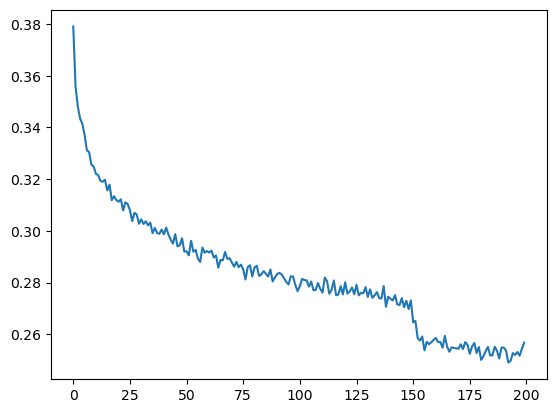

In [36]:
# Taking the mean loss for every 1000 loss calculations
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [37]:
# Evaluation
for layer in model.layers:
    layer.training = False

In [38]:
@torch.no_grad()  # this decorator disables gradient tracking
def split_loss(split):
    """
    Evaluation of the arbitrary data splits

    Args:
        split (str): the name of the split to the evaluated

    Returns:
        Name and Loss of the split
    """
    x, y = {
        "train": (X_train, Y_train),
        "val": (X_dev, Y_dev),
        "test": (X_test, Y_test),
    }[split]
    logits = model(x)
    loss = Func.cross_entropy(logits, y)
    print(split, loss.item())

In [39]:
split_loss("train")
split_loss("val")

train 1.7690284252166748
val 1.9936515092849731


#### Sampling from the model

In [40]:
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        logits = model(torch.tensor([context]))
        probs = Func.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break

    print("".join(itos[i] for i in out))

arlij.
chetta.
heago.
rocklei.
hendrix.
jamylie.
broxin.
denish.
anslibt.
marianah.
astavia.
annayve.
aniah.
jayce.
nodiel.
remita.
niyelle.
jaylene.
aiyan.
aubreana.
